In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
## download Nvidia & AMD stock data
## dataset reference:
## Adaptive Conformal Inference Under Distribution Shift, Gibbs & Candes, 2021

url1 = 'https://github.com/isgibbs/DtACI/raw/refs/heads/main/MajorDailyReturns/NividiaDailyPrices.csv'
url2 = 'https://github.com/isgibbs/DtACI/raw/refs/heads/main/MajorDailyReturns/AMDDailyPrices.csv'

nvidia = pd.read_csv(url1)
amd = pd.read_csv(url2)


In [3]:
nvidia["Date"] = pd.to_datetime(nvidia["Date"], format="%m/%d/%y")

# Reverse into chronological order
nvidia = nvidia.iloc[::-1]

# keep only date & daily open price
nvidia = nvidia.rename(columns={" Open": "price"})
nvidia = nvidia[["Date", "price"]]

# compute return & volatility
nvidia["return"] = nvidia["price"].pct_change()
nvidia["volatility"] = nvidia["return"]**2

# delete 1st day (when return & volatility are not yet defined)
nvidia = nvidia[nvidia["Date"] >= pd.Timestamp("1999-01-25")]
nvidia = nvidia.reset_index(drop=True)

nvidia.head()

,Date,price,return,volatility
0,1999-01-25,1.7708,0.011886,0.000141
1,1999-01-26,1.8333,0.035295,0.001246
2,1999-01-27,1.6771,-0.085202,0.007259
3,1999-01-28,1.6667,-0.006201,0.000038
4,1999-01-29,1.6615,-0.003120,0.000010


In [4]:
amd["Date"] = pd.to_datetime(amd["Date"], format="%m/%d/%y")

# Reverse into chronological order
amd = amd.iloc[::-1]

# keep only date & daily open price
amd = amd.rename(columns={" Open": "price"})
amd = amd[["Date", "price"]]

# compute return & volatility
amd["return"] = amd["price"].pct_change()
amd["volatility"] = amd["return"]**2

# filter to get the same time span as Nvidia
amd = amd[amd["Date"] >= pd.Timestamp("1999-01-25")]
amd = amd.reset_index(drop=True)

amd.head()

,Date,price,return,volatility
0,1999-01-25,11.0625,0.066265,0.004391
1,1999-01-26,10.8750,-0.016949,0.000287
2,1999-01-27,11.0625,0.017241,0.000297
3,1999-01-28,11.0000,-0.005650,0.000032
4,1999-01-29,11.5625,0.051136,0.002615


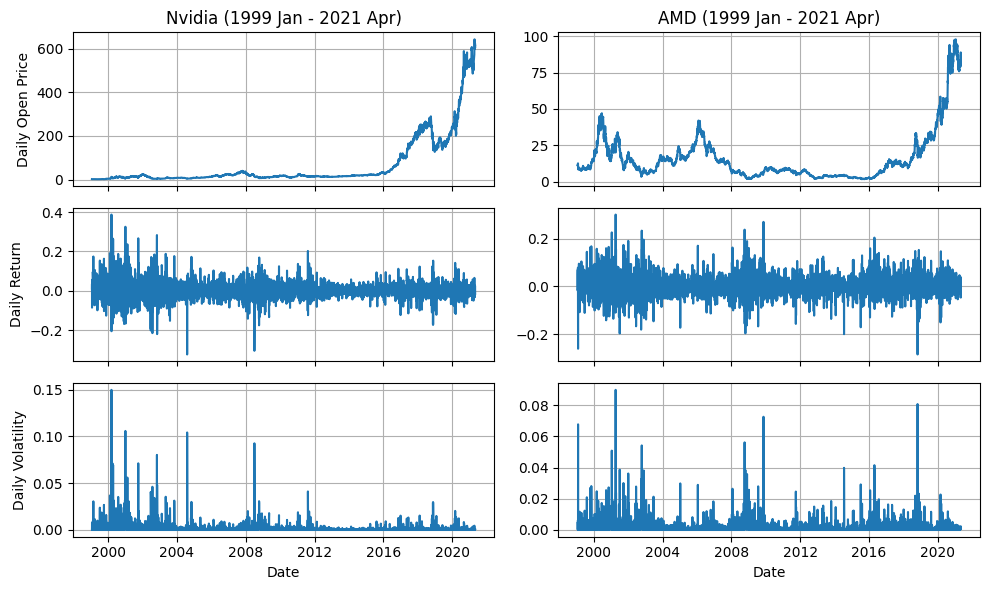

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)

# --- Price plot ---
x = nvidia["Date"].to_numpy()
y = nvidia["price"].to_numpy()
axes[0,0].plot(x,y)
axes[0,0].set_ylabel("Daily Open Price")
axes[0,0].grid(True)
axes[0,0].set_title("Nvidia (1999 Jan - 2021 Apr)")

# --- Return plot ---
y = nvidia["return"].to_numpy()
axes[1,0].plot(x, y)
axes[1,0].set_ylabel("Daily Return")
axes[1,0].grid(True)

# --- Volatility plot ---
y = nvidia["volatility"].to_numpy()
axes[2,0].plot(x, y)
axes[2,0].set_ylabel("Daily Volatility")
axes[2,0].set_xlabel("Date")
axes[2,0].grid(True)

# --- Price plot ---
x = amd["Date"].to_numpy()
y = amd["price"].to_numpy()
axes[0,1].plot(x,y)
axes[0,1].grid(True)
axes[0,1].set_title("AMD (1999 Jan - 2021 Apr)")

# --- Return plot ---
y = amd["return"].to_numpy()
axes[1,1].plot(x, y)
axes[1,1].grid(True)

# --- Volatility plot ---
y = amd["volatility"].to_numpy()
axes[2,1].plot(x, y)
axes[2,1].set_xlabel("Date")
axes[2,1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
def sample_data(N, T, colname, indep = False, seed = 0):
    X = np.zeros((N,T))
    Y = np.zeros((N,T))

    n = len(nvidia['Date'])
    assert len(nvidia['Date']) == len(amd['Date'])

    np.random.seed(seed)
    if(indep):
      nvidia_tsamples = np.random.randint(0, n-T+1, size=N)
      amd_tsamples = np.random.randint(0, n-T+1, size=N)
    else:
      nvidia_tsamples = np.random.randint(0, n-T+1, size=N)
      amd_tsamples = np.copy(nvidia_tsamples)

    # X is sampled from nvidia data, Y is sampled from amd data

    for i in range(N):
        X[i, :] = nvidia[colname].to_numpy()[\
                      nvidia_tsamples[i] : (nvidia_tsamples[i]+T)]
        Y[i, :] = amd[colname].to_numpy()[\
                      amd_tsamples[i] : (amd_tsamples[i]+T)]
    return X, Y

def event_detection(N, T, colname, t, indep = False, seed = 0):
    X, Y = sample_data(N, T, colname, indep, seed)

    p_vals = np.zeros(N)

    for i in tqdm(range(N)):
        Psi_matrix = np.add.outer(X[i],Y[i])
        p_vals[i] = np.sum(Psi_matrix >= Psi_matrix[t,t]) / (T**2)
    return p_vals

def sync_detection(N, T, colname, inflate_eps=0, indep = False, seed = 0):
    X, Y = sample_data(N, T, colname, indep, seed)
    X2 = np.concatenate([X, X], axis=1)

    p_vals = np.zeros(N)

    for i in tqdm(range(N)):
        corrs = np.zeros(T)
        for k in range(T):
            corrs[k] = np.corrcoef(X2[i,k:(k+T)],Y[i])[0, 1]

        p_vals[i] = np.sum(corrs + inflate_eps >= corrs[0]) / T
    return p_vals

In [7]:
# run event detection experiment

N = 10000
T = 100
seed = 12345
t_vals = [T//2 - 1, T - 1]
cols = ['price','return','volatility']
p_vals_event = np.zeros((N,3,len(t_vals),2))

for i_t in np.arange(len(t_vals)):
  for i_col in np.arange(3):
    # under the alternative
    p_vals_event[:,i_col,i_t,0] = \
      event_detection(N, T, cols[i_col], t_vals[i_t], False, seed)
    # under the null
    p_vals_event[:,i_col,i_t,1] = \
      event_detection(N, T, cols[i_col], t_vals[i_t], True, seed)


100%|██████████| 10000/10000 [00:00<00:00, 19704.93it/s]


In [8]:
# run synchronicity detection experiment

N = 10000
T = 100
seed = 12345
cols = ['price','return','volatility']
p_vals_sync = np.zeros((N,3,2))

for i_col in np.arange(3):
  # under the alternative
  p_vals_sync[:,i_col,0] = \
      sync_detection(N, T, cols[i_col], 0, False, seed)
  # under the null
  p_vals_sync[:,i_col,1] = \
      sync_detection(N, T, cols[i_col], 0, True, seed)


100%|██████████| 10000/10000 [01:28<00:00, 112.82it/s]


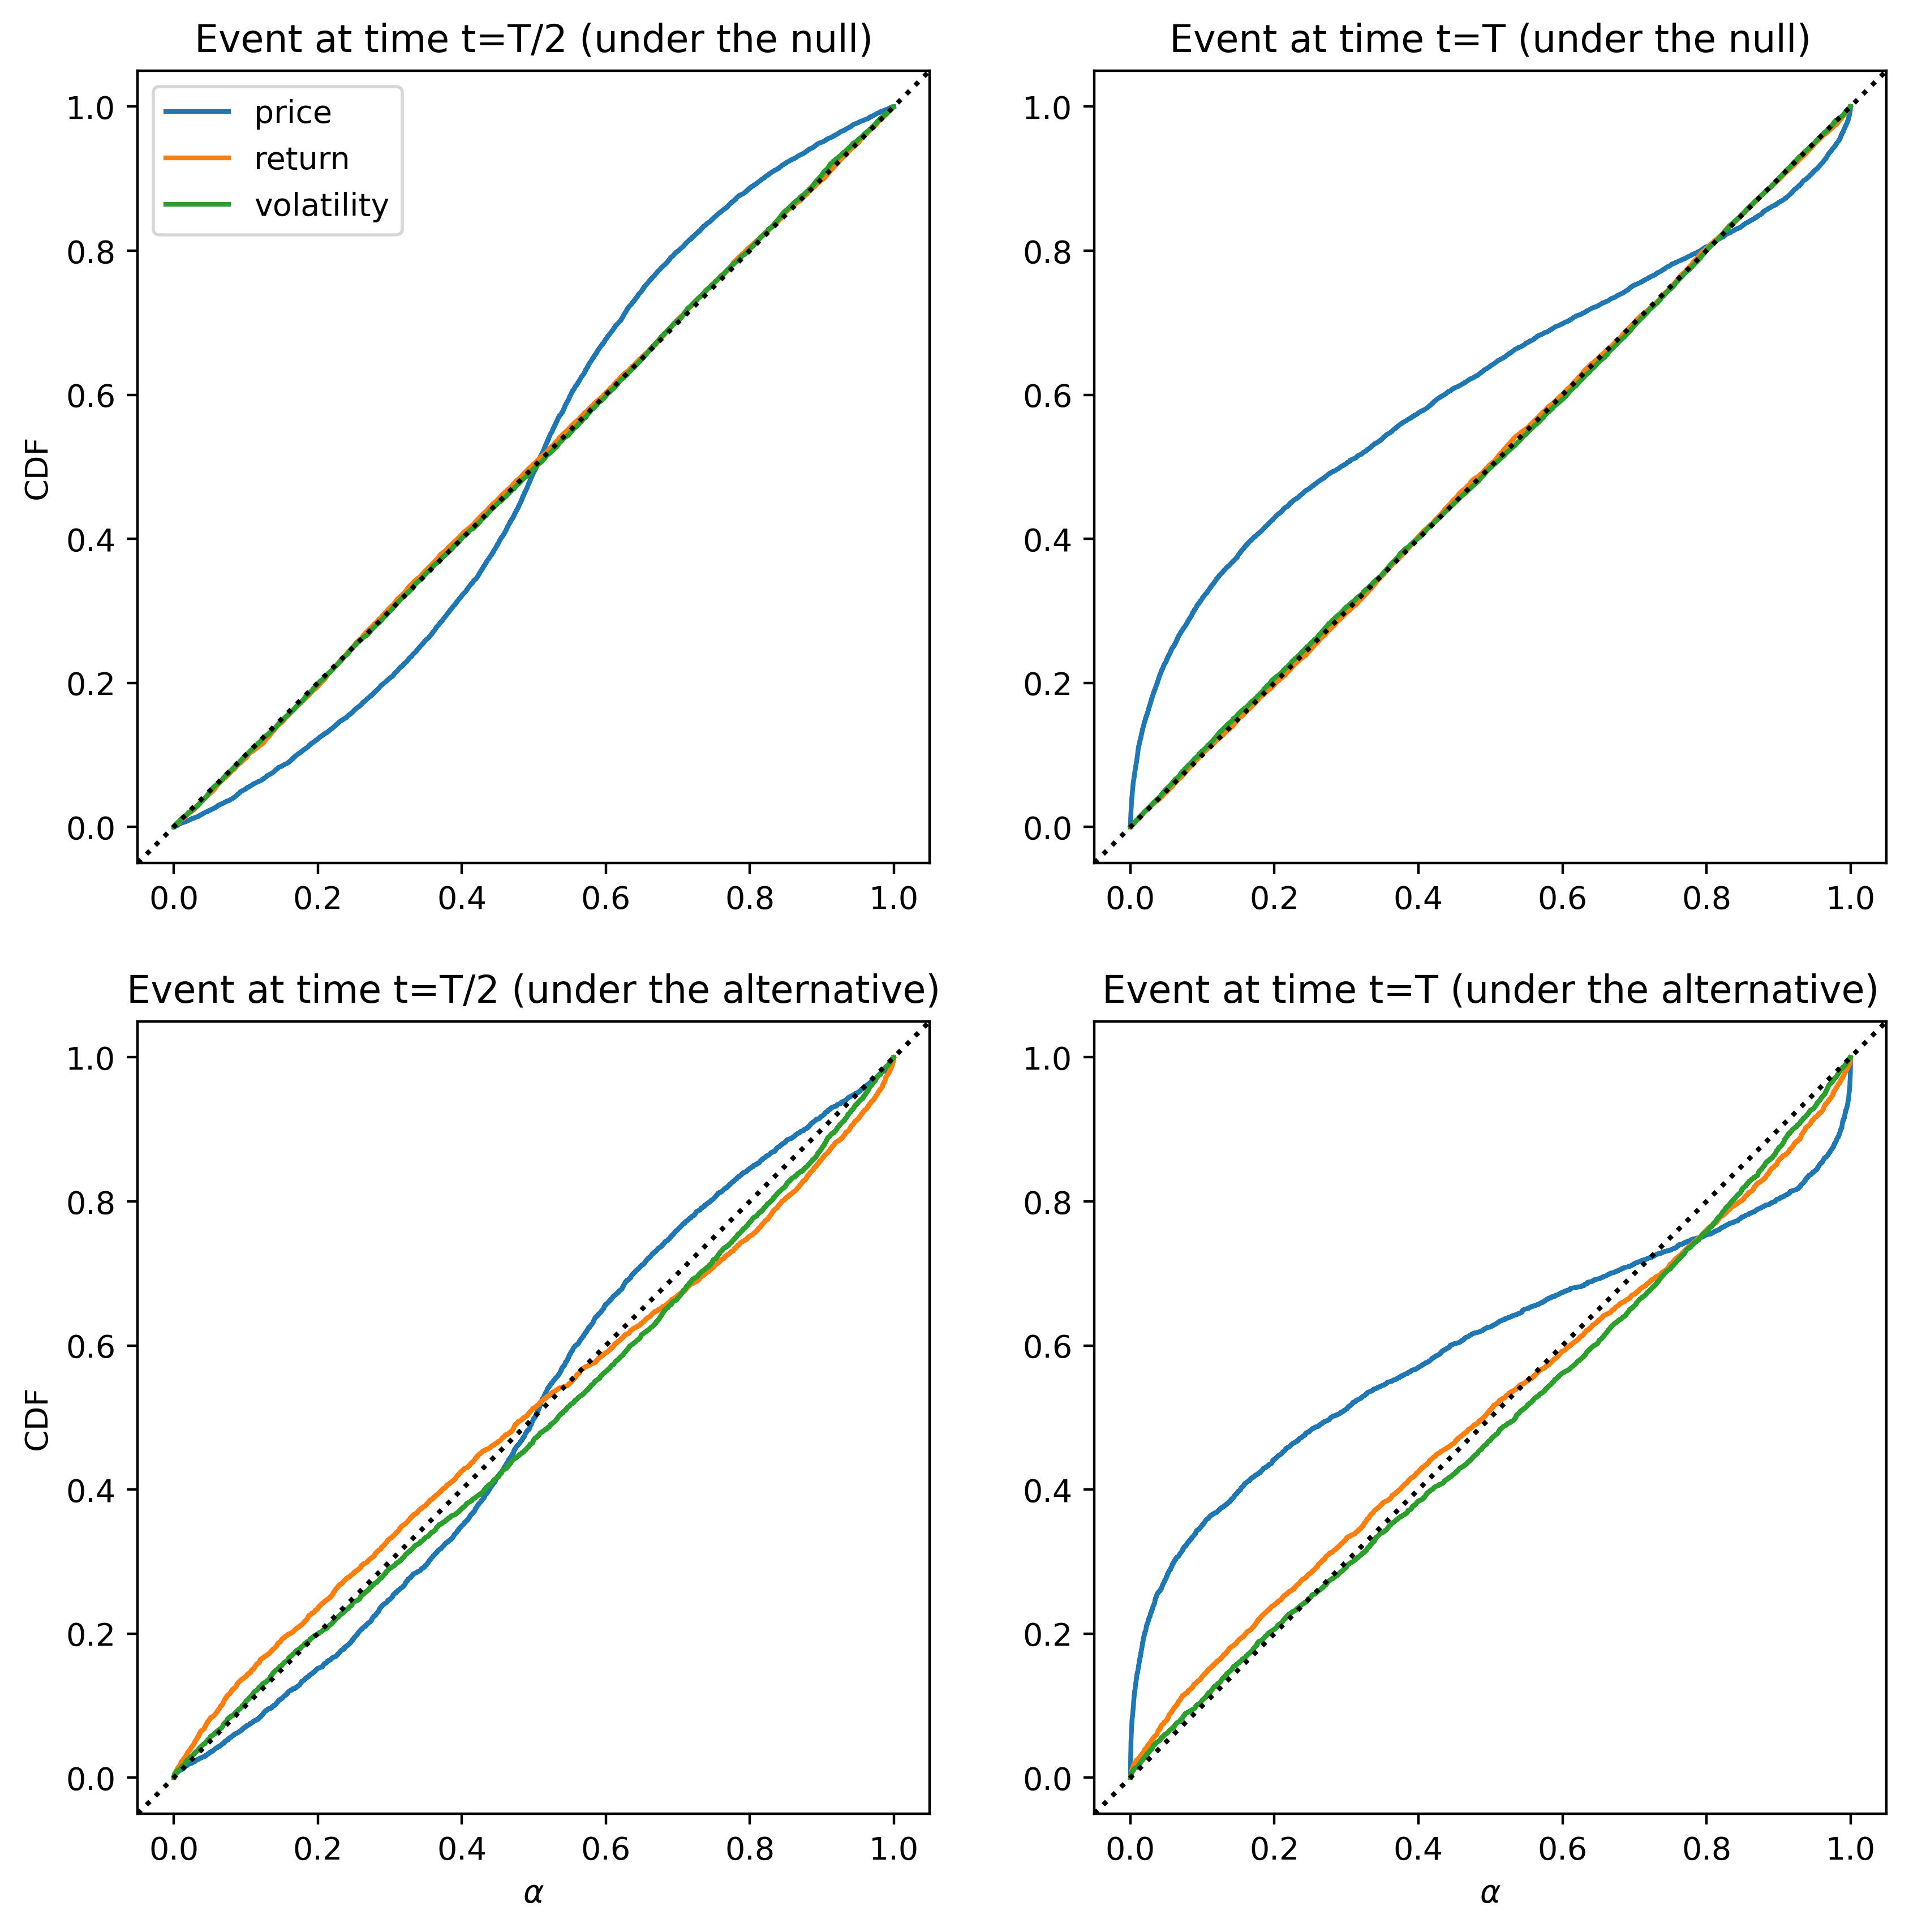

In [9]:
# plot results for detecting events

_, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,10),dpi=400)

for i_col in np.arange(3):
  cdf_grid = np.arange(1,N+1)/(N+1)
  ax1.plot(np.sort(p_vals_event[:,i_col,0,1]),cdf_grid,label=fr"{cols[i_col]}")
  ax2.plot(np.sort(p_vals_event[:,i_col,1,1]),cdf_grid,label=fr"{cols[i_col]}")
  ax3.plot(np.sort(p_vals_event[:,i_col,0,0]),cdf_grid,label=fr"{cols[i_col]}")
  ax4.plot(np.sort(p_vals_event[:,i_col,1,0]),cdf_grid,label=fr"{cols[i_col]}")

ax1.axline((0,0), slope=1, linestyle='dotted', color='black')
ax2.axline((0,0), slope=1, linestyle='dotted', color='black')
ax3.axline((0,0), slope=1, linestyle='dotted', color='black')
ax4.axline((0,0), slope=1, linestyle='dotted', color='black')

ax3.set_xlabel(r"$\alpha$")
ax4.set_xlabel(r"$\alpha$")
ax1.set_ylabel("CDF")
ax3.set_ylabel("CDF")

ax1.set_title("Event at time t=T/2 (under the null)")
ax2.set_title("Event at time t=T (under the null)")
ax3.set_title("Event at time t=T/2 (under the alternative)")
ax4.set_title("Event at time t=T (under the alternative)")

ax1.legend()

ax1.set_box_aspect(aspect=1)
ax2.set_box_aspect(aspect=1)
ax3.set_box_aspect(aspect=1)
ax4.set_box_aspect(aspect=1)
plt.show()

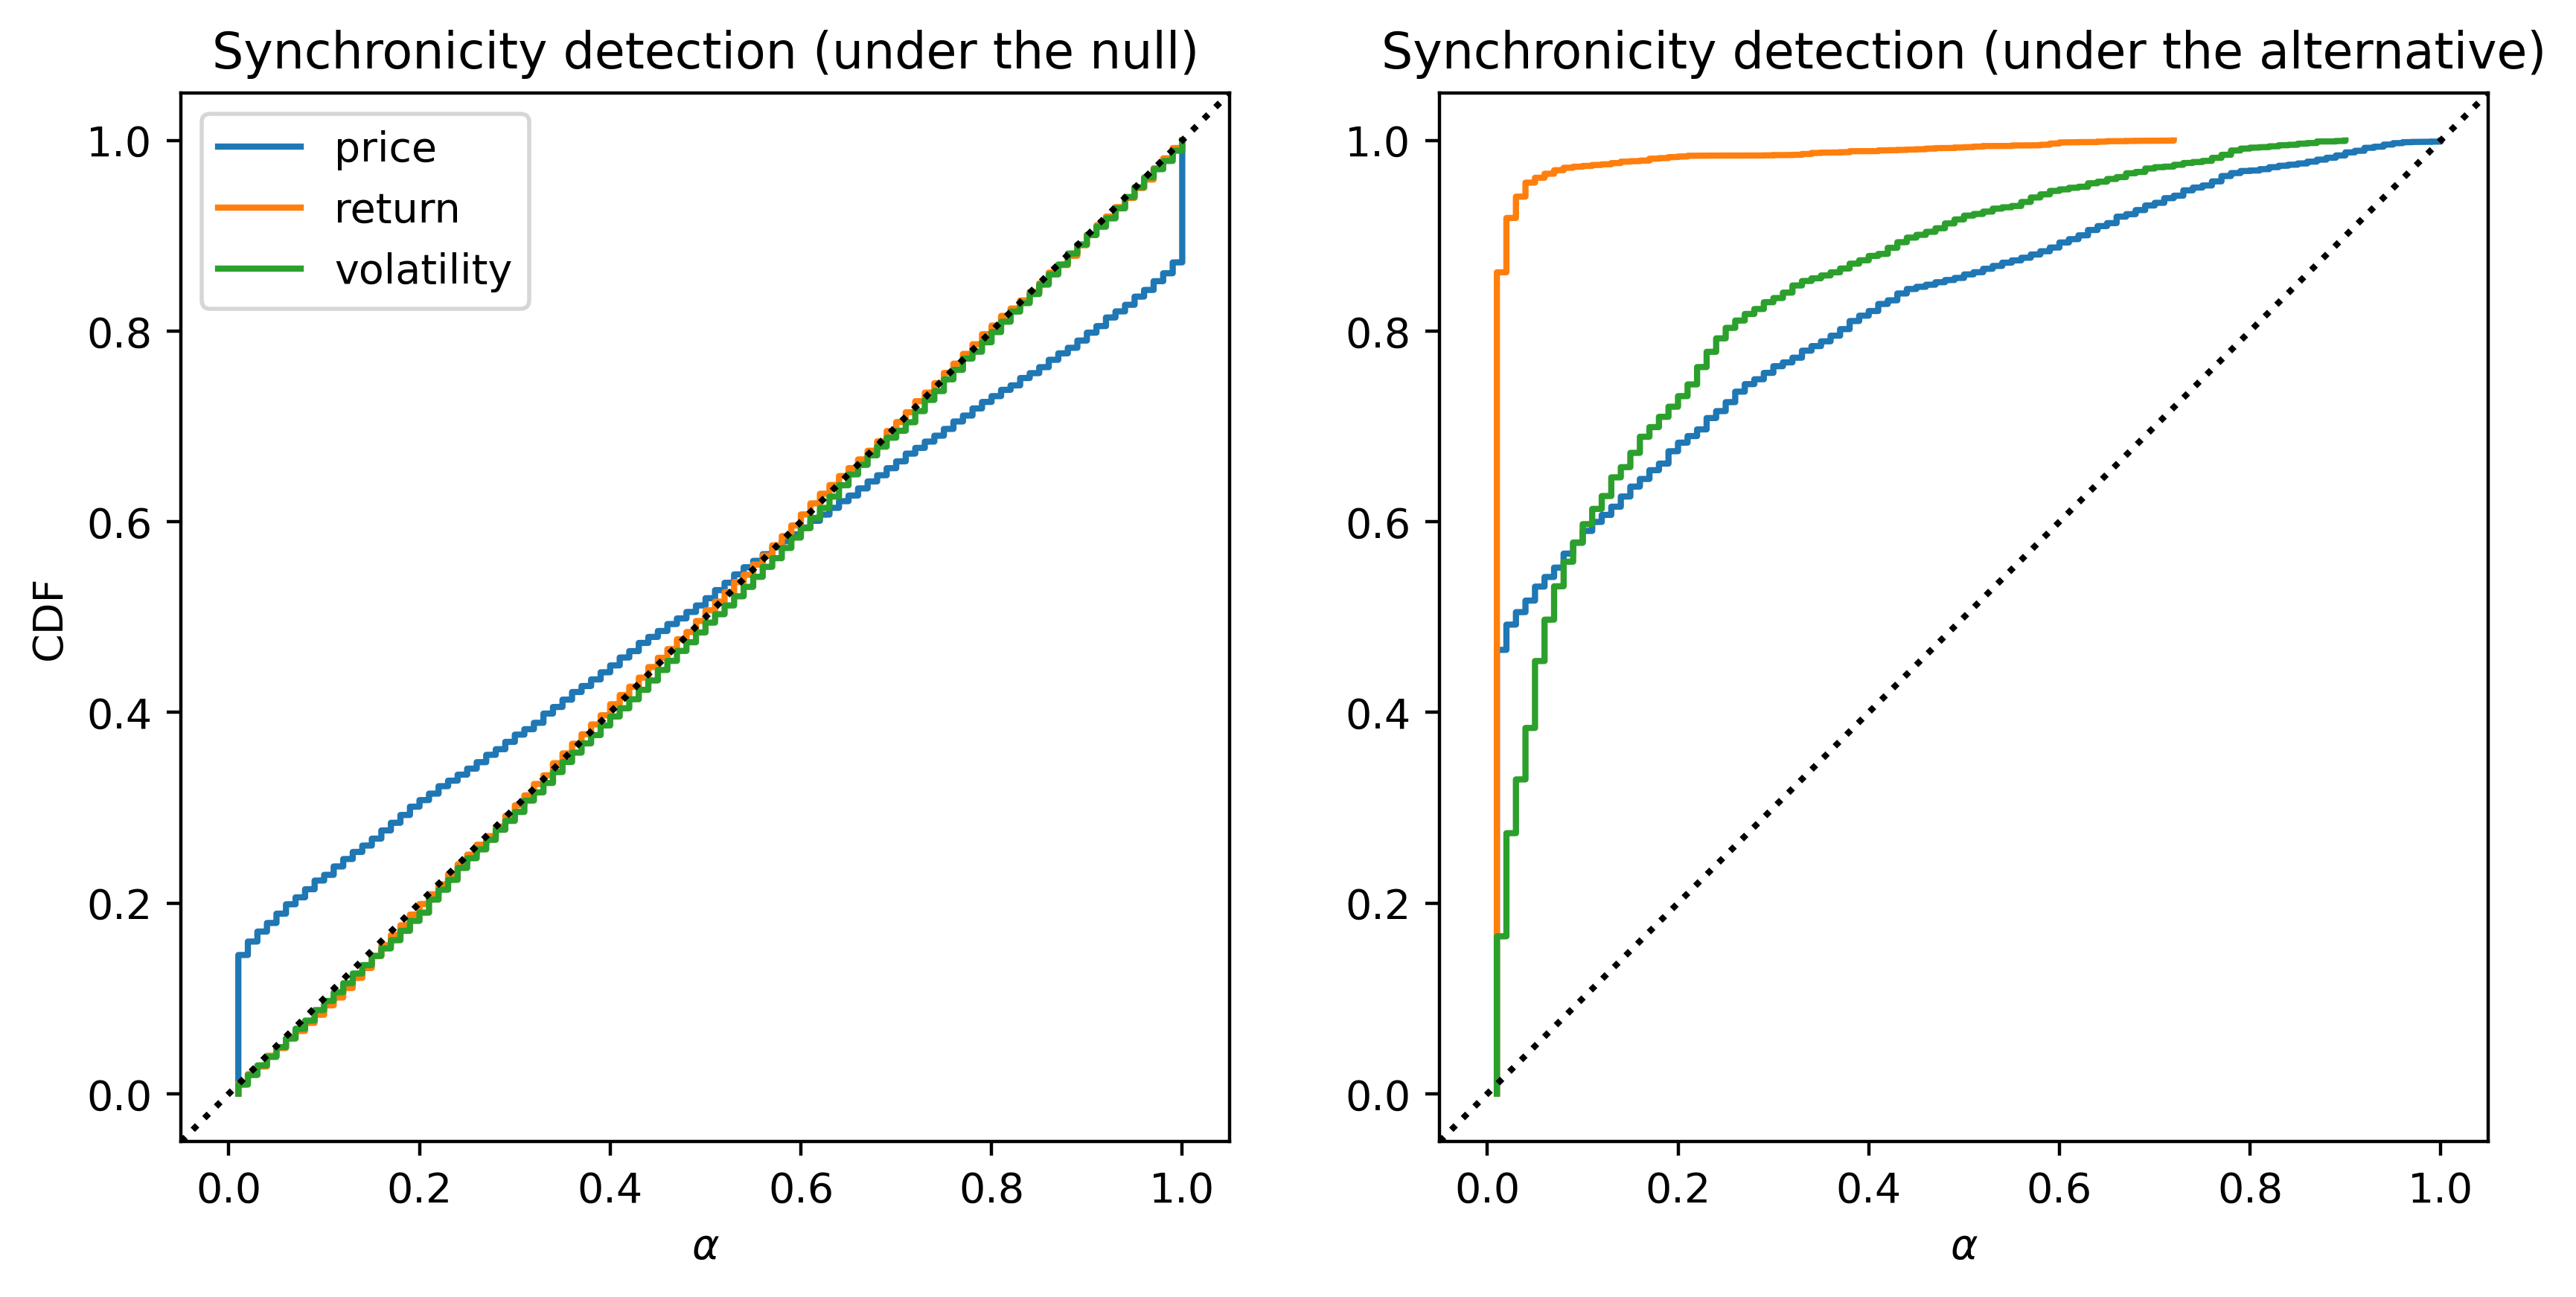

In [10]:
# plot results for detecting synchronicity

_, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=400)

for i_col in np.arange(3):
  cdf_grid = np.arange(1,N+1)/(N+1)
  ax1.plot(np.sort(p_vals_sync[:,i_col,1]),cdf_grid,label=fr"{cols[i_col]}")
  ax2.plot(np.sort(p_vals_sync[:,i_col,0]),cdf_grid,label=fr"{cols[i_col]}")

ax1.axline((0,0), slope=1, linestyle='dotted', color='black')
ax2.axline((0,0), slope=1, linestyle='dotted', color='black')

ax1.set_xlabel(r"$\alpha$")
ax2.set_xlabel(r"$\alpha$")
ax1.set_ylabel("CDF")

ax1.set_title("Synchronicity detection (under the null)")
ax2.set_title("Synchronicity detection (under the alternative)")

ax1.legend()

ax1.set_box_aspect(aspect=1)
ax2.set_box_aspect(aspect=1)
plt.show()